In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run and export ISSM relaxation
# Mikayla Pascual 07/13/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

#import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import pickle

import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

from InterpFromGridToMesh import InterpFromGridToMesh
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d

In [2]:
region = 'SAtoES'
start_year = 1985.

Opening ./Models/SAtoES_inversion.nc for reading 
solidearthsettings.solidearthsettings
lovenumbers.lovenumbers
rotational.rotational
results.solutionstep
empty init


/efs/issm/issm/trunk-jpl/src/m/plot/plotmodel.py:123: MatplotlibDeprecationWarning: 
The 'add_all' parameter of __init__() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'add_all', they should be passed as keyword, not positionally.
  axgrid = ImageGrid(


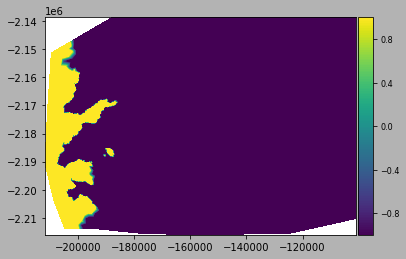

In [3]:
md = loadmodel('./Models/SAtoES_inversion.nc')
md.levelset.spclevelset = np.nan * np.ones((md.mesh.numberofvertices))
pos = md.mesh.vertexonboundary == 1
#pos = np.where(md.mesh.vertexonboundary)
md.levelset.spclevelset[pos] = md.mask.ice_levelset[pos]
md.levelset.migration_max = 1e10
plotmodel(md, 'data', md.mask.ice_levelset)

In [4]:
## Relaxation
#Put results of inversion back into the model for forward runs
md.friction.coefficient=md.results.StressbalanceSolution.FrictionCoefficient
relaxation_years = 30 #try 5 years if 1 runs quickly

# Special post-processing of inverted friction coefficient
filename = 'Exp/' +region+ '_coeffront_after_inversion.exp'
if os.path.isfile(filename):
  pos = find(ContourToNodes(md.mesh.x, md.mesh.y, filename, 1))
  md.friction.coefficient[pos] = 10

md.initialization.pressure = np.zeros([md.mesh.numberofvertices,1])
md.initialization.temperature = 250*np.ones([md.mesh.numberofvertices,1]) #temperature is in kelvin

# Set parameters
md.inversion.iscontrol=0;
md.timestepping.start_time = start_year;
md.timestepping.time_step  = .02;
md.timestepping.final_time = start_year + relaxation_years;
md.settings.output_frequency = (1/md.timestepping.time_step)/5; # 5/yr

In [5]:
#with open('ens_dict.pickle', 'rb') as f:
    #ens_data = pickle.load(f)

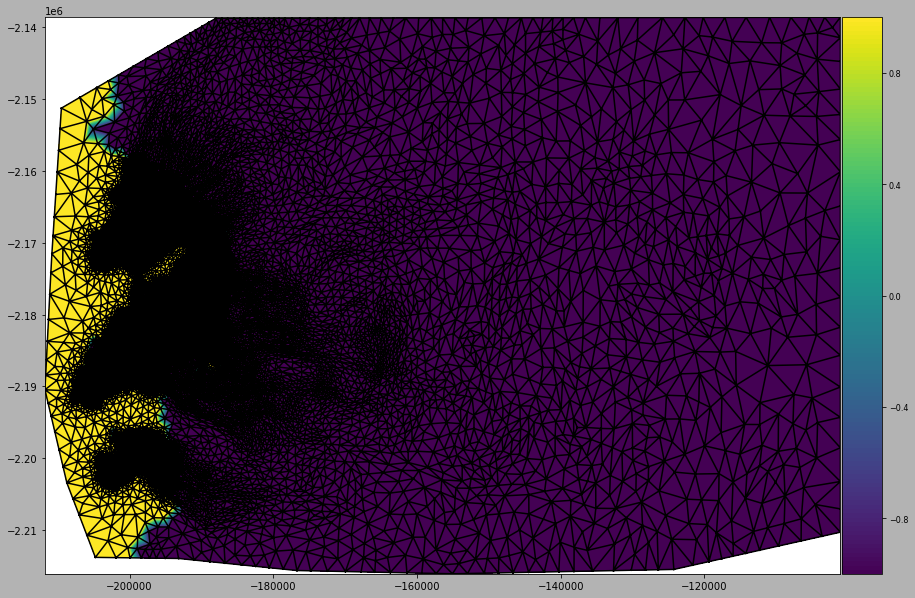

In [6]:
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', md.mask.ice_levelset, 'edgecolor', 'k')

#plt.xlim(-215000, -190000)
#plt.ylim(-2210000, -2170000)

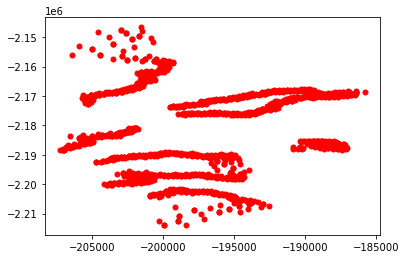

In [7]:
# define fjord walls/flush where bed > 0 (code added 8/3/22)
n_buffer = 2
for i in range(n_buffer):
    elements = md.mesh.elements.astype(int)-1
    nodes_edge = elements[np.where(np.sum(md.mask.ice_levelset[elements] == -1, axis=1) == 2)[0]]
    nodes_edge = np.unique(nodes_edge.ravel())
    nodes_bed = np.where(md.geometry.bed > 0)[0]
    nodes_edge_bed = np.array(list(set(nodes_edge) & set(nodes_bed)))
    plt.plot(md.mesh.x[nodes_edge_bed], md.mesh.y[nodes_edge_bed], 'r.', markersize=10)

    md.mask.ice_levelset[nodes_edge_bed] = -1
    md.geometry.thickness[nodes_edge_bed] = 10
    md.geometry.surface[nodes_edge_bed] = md.geometry.bed[nodes_edge_bed] + md.geometry.thickness[nodes_edge_bed]

    md.friction.coefficient[nodes_edge_bed] = 200

In [8]:
# defining thermal and sub. discharge at every ISSM mesh node 

# load raster of basins
ds = gdal.Open('./Cheat_matfiles/tidewaterbasins_rignotid.mat_tidewaterbasins.tif', gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
basins_array = rb.ReadAsArray()

gt = ds.GetGeoTransform()
ulx, xres, xskew, uly, yskew, yres  = gt
lrx = ulx + (ds.RasterXSize * xres)
lry = uly + (ds.RasterYSize * yres)
x = np.arange(ulx, lrx,  xres)
y = np.arange(lry, uly, -yres)

In [9]:
# interpolate basin to each mesh node 
px = np.array( ((md.mesh.x - gt[0]) / gt[1]).astype(int) )
py = np.array( ((md.mesh.y - gt[3]) / gt[5]).astype(int) )

basins_mesh = basins_array[py.astype(int), px.astype(int)]
basins_mesh[basins_mesh==-9999] = 0

In [10]:
# Assigning ocean thermal (EN4) and subglacial discharge (RACMO2.3p2) forcings
from scipy_io_utils import *

# Load historical forcing data
glacier_list = list()
m = loadmat('./Cheat_matfiles/glacier0013.mat')
glacier0013 = m['glacier0013']
m = loadmat('./Cheat_matfiles/glacier0052.mat')
glacier0052 = m['glacier0052']
m = loadmat('./Cheat_matfiles/glacier0053.mat')
glacier0053 = m['glacier0053']
m = loadmat('./Cheat_matfiles/glacier0090.mat')
glacier0090 = m['glacier0090']

# Thermal forcing
t = glacier0013['EN4']['t']
TF = glacier0013['EN4']['TF']

# Discharge
t = glacier0013['RACMO']['Q']
Q = glacier0013['RACMO']['Q']

from frontalforcingsrignot import frontalforcingsrignot
md.frontalforcings = frontalforcingsrignot()
md.frontalforcings.thermalforcing = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['EN4']['TF'])) )
md.frontalforcings.subglacial_discharge = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['RACMO']['Q'])) )

In [11]:
# Assign forcings to correct node 

# step 1: find which nodes belong to each basin using basin_mesh
get_indexes = lambda basins_mesh, xs: [i for (y, i) in zip(xs, range(len(xs))) if basins_mesh == y]
glacier13_nodes = get_indexes(13,basins_mesh)
glacier52_nodes = get_indexes(52,basins_mesh)
glacier53_nodes = get_indexes(53,basins_mesh)
glacier90_nodes = get_indexes(90,basins_mesh)

# NOTE: Denis combined steps 2 and 3: we select the rows and set to the TF time series
# step 2: select() rows from frontalforcings.thermal that correspond to step 1 nodes
md.frontalforcings.thermalforcing[glacier13_nodes,:] = glacier0013['EN4']['TF']
md.frontalforcings.thermalforcing[glacier52_nodes,:] = glacier0052['EN4']['TF']
md.frontalforcings.thermalforcing[glacier53_nodes,:] = glacier0053['EN4']['TF']
md.frontalforcings.thermalforcing[glacier90_nodes,:] = glacier0090['EN4']['TF']

# step 2: select() rows from frontalforcings.subglacial_discharge that correspond to step 1 nodes
md.frontalforcings.subglacial_discharge[glacier13_nodes,:] = glacier0013['RACMO']['Q']
md.frontalforcings.subglacial_discharge[glacier52_nodes,:] = glacier0052['RACMO']['Q']
md.frontalforcings.subglacial_discharge[glacier53_nodes,:] = glacier0053['RACMO']['Q']
md.frontalforcings.subglacial_discharge[glacier90_nodes,:] = glacier0090['RACMO']['Q']

# NOTE: And now, set the last row to the time
md.frontalforcings.thermalforcing[-1,:] = glacier0013['EN4']['t']
md.frontalforcings.subglacial_discharge[-1,:] = glacier0013['RACMO']['t']

# NOTE: All times are the same for the TF time series for each glacier so we just set the times equal to the glacier0013 times

In [12]:
md.frontalforcings

   Frontalforcings parameters:
         basin                  : N/A             -- basin ID for vertices
         numberofbasins         : 0.0             -- number of basins
         subglacial_discharge   : (12113, 720)    -- sum of subglacial discharge for each basin [m / d]
         thermalforcing         : (12113, 118)    -- thermal forcing [C]

In [21]:
#for ensemble_ID in ens_data.keys():
# set up to run all 10 in one run
#ensemble_ID = 'Trial9' # change ID for each Trial value
#subglacial_discharge = ens_data[ensemble_ID]['sd_after']
#thermal_forcing = ens_data[ensemble_ID]['tf_after']
#calving = ens_data[ensemble_ID]['calve_after']

#print(ensemble_ID)
#print(subglacial_discharge)
#print(thermal_forcing)
#print(calving)
#continue

# We set the transient parameters
md.transient.ismovingfront=1
md.transient.isthermal=0
md.transient.isstressbalance=1
md.transient.ismasstransport=1
md.transient.isgroundingline=1
md.groundingline.migration = 'SubelementMigration'

# We set the ocean conditions
from frontalforcingsrignot import frontalforcingsrignot
md.frontalforcings = frontalforcingsrignot()

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
md.frontalforcings.subglacial_discharge = 2.6 * np.ones(md.mesh.numberofvertices) + 0.05003857059290104 #add LHS value
md.frontalforcings.thermalforcing = 15.7 * np.ones(md.mesh.numberofvertices) + -2.0840162904433726 #add LHS value

pos = np.where(md.geometry.bed > 0)[0]
md.frontalforcings.subglacial_discharge[pos] = np.nan
md.frontalforcings.thermalforcing[pos] = np.nan
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

md.frontalforcings.basin = 1 * np.ones(md.mesh.numberofvertices)
md.frontalforcings.numberofbasins = 1

# We set the calving model (no moving front ... spclevelset is actually ignored)
from calvingvonmises import calvingvonmises
md.calving = calvingvonmises()

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
md.calving.stress_threshold_groundedice = 2000000.0 #replace with LHS value
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#md.levelset.spclevelset = np.nan * np.ones([md.mesh.numberofvertices,1])
#md.calving.calvingrate = np.zeros([md.mesh.numberofvertices,1])
#md.frontalforcings.meltingrate = np.zeros([md.mesh.numberofvertices,1])
#md.calving.meltingrate = np.ones([md.mesh.numberofvertices,1])

# Set the requested outputs
md.stressbalance.requested_outputs=['default']
md.transient.requested_outputs=['default','IceVolumeAboveFloatation']

# Go solve
md.verbose.solution=1
import importlib
import generic_daskhub
importlib.reload(generic_daskhub)
from generic_daskhub import generic_daskhub

from socket import gethostname
md.cluster = generic_daskhub('name', gethostname(), 'np', 16)

md.settings.waitonlock = 9999 #np.inf
md.cluster.interactive = 0

from solve import solve
md = solve(md, 'tr')

from export_netCDF import export_netCDF

md.inversion.cost_functions = md.inversion.cost_functions.astype(np.float64)
for i in range(len(md.results.TransientSolution)):
    md.results.TransientSolution[i].step = np.float64(md.results.TransientSolution[i].step)

#export_netCDF(md, "./Models/SAtoES_relaxation_" +ensemble_ID+ ".nc")
export_netCDF(md, "./Models/SAtoES_relaxation_control.nc")

checking model consistency
marshalling file SAtoES.bin
uploading input file and queueing script
launching solution sequence on remote cluster
waiting for /efs/issm/issm/trunk-jpl/execution/SAtoES-09-13-2022-03-22-19-352/SAtoES.lock hold on... (Ctrl+C to exit)
loading results from cluster
File ./Models/SAtoES_relaxation_control.nc allready exist


Give a new name or "delete" to replace:  delete


field md.solidearth.external is None
qmu is skipped until it is more stable


In [22]:
#md = loadmodel('./Models/SAtoES_relaxation_Trial9.nc')
md = loadmodel('./Models/SAtoES_relaxation_control.nc')

Opening ./Models/SAtoES_relaxation_control.nc for reading 
solidearthsettings.solidearthsettings
lovenumbers.lovenumbers
rotational.rotational
results.results
results.solutionstep
empty init
WARNING, StressbalanceConvergenceNumSteps is not present on every times, we chose DimNum10(1) as the dimension to write it with


In [23]:
md.results.TransientSolution

  1x151 struct array with fields:

    StressbalanceConvergenceNumSteps
    step
    time
    Vel
    Pressure
    Vx
    Vy
    MaskIceLevelset
    Thickness
    Surface
    Base
    MaskOceanLevelset
    SmbMassBalance
    IceVolumeAboveFloatation
    SolutionType

/efs/issm/issm/trunk-jpl/src/m/plot/plotmodel.py:123: MatplotlibDeprecationWarning: 
The 'add_all' parameter of __init__() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'add_all', they should be passed as keyword, not positionally.
  axgrid = ImageGrid(


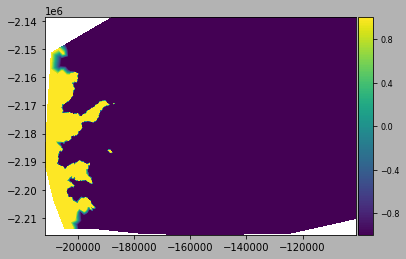

In [24]:
plotmodel(md, 'data', np.array(md.mask.ice_levelset))

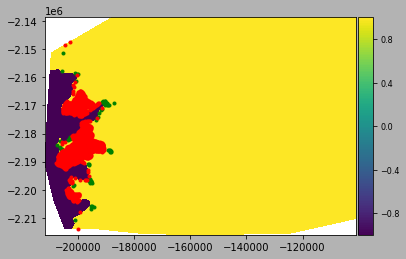

In [25]:
time = [md.results.TransientSolution[i].time for i in range(len(md.results.TransientSolution))]
VAF = [md.results.TransientSolution[i].IceVolumeAboveFloatation for i in range(len(md.results.TransientSolution))]

# Look for terminus advance
idx = np.logical_and(np.array(md.mask.ice_levelset) > 0, \
                     np.array(md.results.TransientSolution[150].MaskIceLevelset).ravel() <= 0)
pos_advance = np.where(idx)[0]

# Look for terminus retreat
idx = np.logical_and(np.array(md.mask.ice_levelset) < 0, \
                     np.array(md.results.TransientSolution[150].MaskIceLevelset).ravel() >= 0)
pos_retreat = np.where(idx)[0]

#fig = plt.figure(figsize=(10,10))
#plotmodel(md, 'data', np.array(md.mask.ice_levelset), \
#              'data', np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel(), \
#              'caxis#all', [-1., +1.])
plotmodel(md, 'data', np.array(md.mask.ice_levelset) - np.array(md.results.TransientSolution[149].MaskIceLevelset).ravel(), \
              'caxis#all', [-1, +1])

plt.plot(md.mesh.x[pos_advance], md.mesh.y[pos_advance], 'g.')
plt.plot(md.mesh.x[pos_retreat], md.mesh.y[pos_retreat], 'r.')

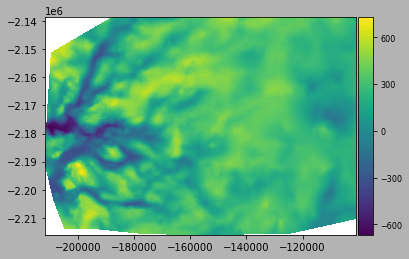

In [16]:
plotmodel(md,'data', md.geometry.bed)

In [17]:
md.levelset

   Level-set parameters:
         stabilization          : 1               -- 0: no, 1: artificial_diffusivity, 2: streamline upwinding
         spclevelset            : (12112,)        -- Levelset constraints (NaN means no constraint)
         reinit_frequency       : 5               -- Amount of time steps after which the levelset function in re-initialized
         kill_icebergs          : 1               -- remove floating icebergs to prevent rigid body motions (1: true, 0: false)
         migration_max          : 10000000000.0   -- maximum allowed migration rate (m/a)
         fe                     : 'P1'            -- Finite Element type: 'P1' (default), or 'P2'

IndexError: arrays used as indices must be of integer (or boolean) type

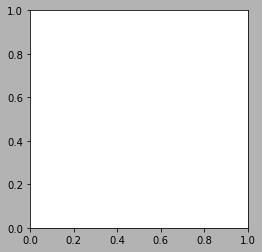

In [12]:
plotmodel(md, 'data', 'BC')

In [10]:
md.results.TransientSolution[5].MaskIceLevelset

array([[-16710.24741481],
       [  5284.22963663],
       [  4062.45684144],
       ...,
       [  -812.40708016],
       [ -1777.59417679],
       [-89056.42866602]])

In [25]:
md.calving

   Calving VonMises parameters:
         stress_threshold_gro...: 500000.0        -- sigma_max applied to grounded ice only [Pa]
         stress_threshold_flo...: 150000.0        -- sigma_max applied to floating ice only [Pa]
         min_thickness          : 0.0             -- minimum thickness below which no ice is allowed [m]